# Generate Census Data
In this notebook we generate Income Classified Census Sector data for later use in our project.

In [2]:
import pandas as pd
import geopandas as gpd
import utm

import seaborn as sns
import matplotlib.pyplot as plt

import random
random.seed(42)

First, let import 2010 Census Shapefile with Census Sectors Geometries. These files can be found at the IBGE website, on [this link](ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/censo_2010/setores_censitarios_shp/sp/sp_setores_censitarios.zip)

In [62]:
df_sectors = gpd.read_file("./data/setor_censitario/35SEE250GC_SIR.shp")
df_sectors.drop([
    "CD_GEOCODB",
    "CD_GEOCODD",
    "CD_GEOCODM",
    "CD_GEOCODS",
    "ID"
], 1, inplace=True)

#Renaming columns
df_sectors.columns = [
    'COD_SETOR', 
    'NM_BAIRRO', 
    'NM_DISTRIT', 
    'NM_MESO', 
    'NM_MICRO',
    'NM_MUNICIP', 
    'NM_SUBDIST', 
    'TIPO', 
    'geometry'    
]
df_sectors["COD_SETOR"] = pd.to_numeric(df_sectors["COD_SETOR"])
df_sectors.set_index("COD_SETOR", inplace=True)
df_sectors.head()

,NM_BAIRRO,NM_DISTRIT,NM_MESO,NM_MICRO,NM_MUNICIP,NM_SUBDIST,TIPO,geometry
COD_SETOR,,,,,,,,
350280405000312,,ARAÇATUBA,ARAÇATUBA,ARAÇATUBA,ARAÇATUBA,,URBANO,"POLYGON ((-50.44838799999999 -21.234323, -50.4..."
350280405000313,,ARAÇATUBA,ARAÇATUBA,ARAÇATUBA,ARAÇATUBA,,URBANO,"POLYGON ((-50.437312 -21.235499, -50.438358 -2..."
350280405000314,,ARAÇATUBA,ARAÇATUBA,ARAÇATUBA,ARAÇATUBA,,URBANO,"POLYGON ((-50.433906 -21.231727, -50.436319999..."
350280405000315,,ARAÇATUBA,ARAÇATUBA,ARAÇATUBA,ARAÇATUBA,,URBANO,"POLYGON ((-50.448995 -21.15865, -50.451147 -21..."
350280405000316,,ARAÇATUBA,ARAÇATUBA,ARAÇATUBA,ARAÇATUBA,,URBANO,"POLYGON ((-50.444699 -21.168378, -50.444818 -2..."


Let's check if everything is in order. To do that, let's plot the Census Sectors for the Vila Mariana district.

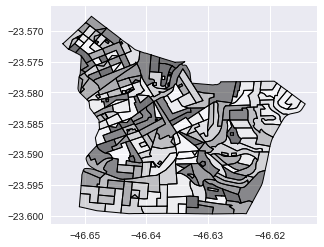

In [53]:
%matplotlib inline
ax = df_sectors[df_sectors["NM_DISTRIT"] == "VILA MARIANA"].plot()

Census geometries by itself are not very useful. For our purposes here (Classifying income from a snapshot of a residence) we will agreggate the census data to these geometries.

This data can be found also at the IBGE website, although at a [different address](ftp://ftp.ibge.gov.br/Censos/Censo_Demografico_2010/Resultados_do_Universo/Agregados_por_Setores_Censitarios/SP_Capital_20150728.zip)

We are getting only São Paulo City data, as we are restricting our scope to this city, but data for other regions can be found in the website as well. Census metadata is also found at this website, on [this link](ftp://ftp.ibge.gov.br/Censos/Censo_Demografico_2010/Resultados_do_Universo/Agregados_por_Setores_Censitarios/1_Documentacao_Agregado_dos_Setores_2010_20150527.zip)

For our work here, we will be using manly two of the census data files:

- Basico_SP1.csv: Contains basic information over the census sector.
- DomicilioRenda_SP1.csv: Contains aggregated household income information over the census sector.

With this two files we are able to calculate average household income per capita in a census sector, which we are going to be using as target variable to train our model.

First, let's import the Basic Information File

In [54]:
df_basic = pd.read_csv(
    "./data/setor_censitario/Basico_SP1.csv",
    sep=";",
    encoding="cp1252",
    usecols=["Cod_setor", "Situacao_setor", "V002"],    
)
df_basic.columns = ["COD_SETOR", "SIT_SETOR", "POPULATION"]
df_basic.set_index("COD_SETOR", inplace=True)
df_basic.head()

,SIT_SETOR,POPULATION
COD_SETOR,,
355030801000001,1,800.0
355030801000002,1,913.0
355030801000003,1,625.0
355030801000004,1,572.0
355030801000005,1,754.0


Then, let's import the Household income file.

In [72]:
df_income = pd.read_csv(
    "./data/setor_censitario/DomicilioRenda_SP1.csv",
    sep=";",
    encoding="cp1252",
    usecols=["Cod_setor", "V002"]
)

df_income.columns = ["COD_SETOR", "TOTAL_INCOME"]
#There are some X values in the total income field that we will be treating as missing data
df_income["TOTAL_INCOME"] = pd.to_numeric(df_income["TOTAL_INCOME"], errors="coerce")
df_income.set_index("COD_SETOR", inplace=True)
df_income.head()

,TOTAL_INCOME
COD_SETOR,
355030801000001,907777.0
355030801000002,846525.0
355030801000003,505662.0
355030801000004,446011.0
355030801000005,615215.0


Let's join all three files in one big dataframe. We will keep only the necessary fields.

In [111]:
df_temp = pd.merge(
    df_basic, 
    df_income, 
    how="inner", 
    left_index=True, 
    right_index=True
)

df_final = pd.merge(
    df_sectors,
    df_temp,
    how="inner",
    left_index=True,
    right_index=True
)

df_final["MEAN_INCOME"] = df_final["TOTAL_INCOME"] / df_final["POPULATION"]
df_final.head()

,NM_BAIRRO,NM_DISTRIT,NM_MESO,NM_MICRO,NM_MUNICIP,NM_SUBDIST,TIPO,geometry,SIT_SETOR,POPULATION,TOTAL_INCOME,MEAN_INCOME
COD_SETOR,,,,,,,,,,,,
355030804000079,,ARICANDUVA,METROPOLITANA DE SÃO PAULO,SÃO PAULO,SÃO PAULO,,URBANO,"POLYGON ((-46.517785 -23.579474, -46.517864 -2...",1,554.0,432103.0,779.969314
355030804000080,,ARICANDUVA,METROPOLITANA DE SÃO PAULO,SÃO PAULO,SÃO PAULO,,URBANO,"POLYGON ((-46.518881 -23.579667, -46.519082 -2...",1,713.0,449239.0,630.068724
355030804000081,,ARICANDUVA,METROPOLITANA DE SÃO PAULO,SÃO PAULO,SÃO PAULO,,URBANO,"POLYGON ((-46.520151 -23.581046, -46.52026 -23...",1,685.0,411373.0,600.544526
355030804000082,,ARICANDUVA,METROPOLITANA DE SÃO PAULO,SÃO PAULO,SÃO PAULO,,URBANO,"POLYGON ((-46.5214 -23.579917, -46.521437 -23....",1,902.0,629889.0,698.324834
355030804000083,,ARICANDUVA,METROPOLITANA DE SÃO PAULO,SÃO PAULO,SÃO PAULO,,URBANO,"POLYGON ((-46.523712 -23.581848, -46.523838 -2...",1,602.0,320125.0,531.769103


Let's take a look on income distribution

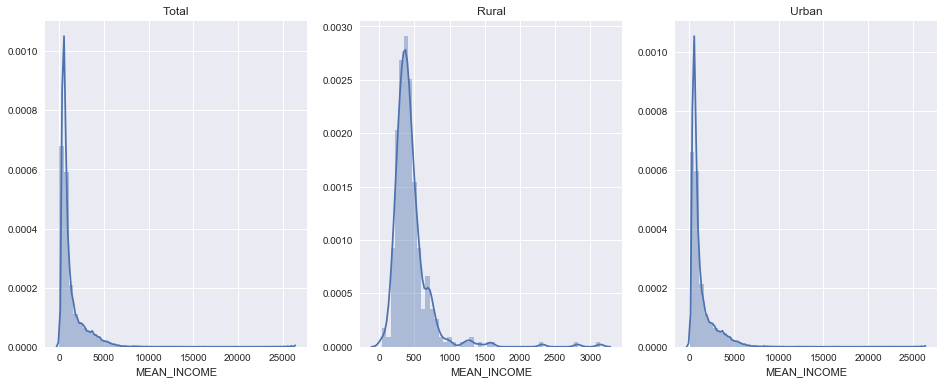

In [112]:
%matplotlib inline

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,6),)

ax1.set_title("Total")
sns.distplot(df_final["MEAN_INCOME"].dropna(), ax=ax1)

ax2.set_title("Rural")
sns.distplot(df_final.loc[
    (df_final["TIPO"] == "RURAL"),
    "MEAN_INCOME"
].dropna(), ax=ax2)

ax3.set_title("Urban")
sns.distplot(df_final.loc[
    (df_final["TIPO"] == "URBANO"),
    "MEAN_INCOME"
].dropna(), ax=ax3)

We can easily see that the distribution in pretty damn skewed (As expected. Income distribution tend to have heavy tails). Let's calculate the logarithmic income then, and check it's distribution.

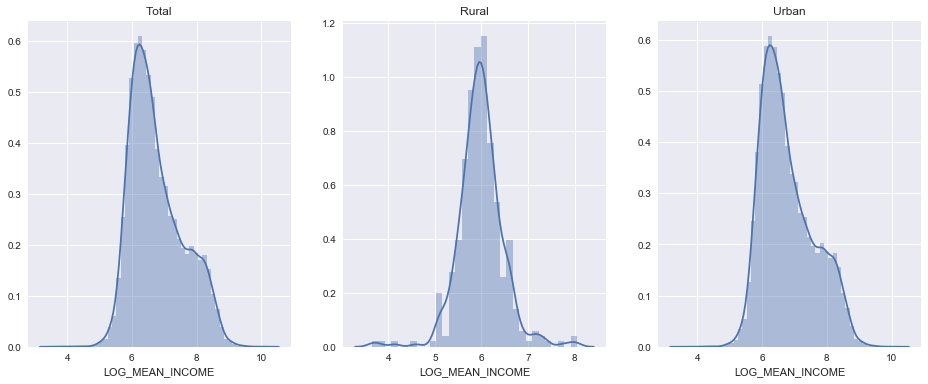

In [113]:
%matplotlib inline
from math import log

df_final["LOG_MEAN_INCOME"] = df_final["MEAN_INCOME"].map(log)

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,6),)

ax1.set_title("Total")
sns.distplot(df_final["LOG_MEAN_INCOME"].dropna(), ax=ax1)

ax2.set_title("Rural")
sns.distplot(df_final.loc[
    (df_final["TIPO"] == "RURAL"),
    "LOG_MEAN_INCOME"
].dropna(), ax=ax2)

ax3.set_title("Urban")
sns.distplot(df_final.loc[
    (df_final["TIPO"] == "URBANO"),
    "LOG_MEAN_INCOME"
].dropna(), ax=ax3)

To see if our results are making any sense, let's plot the Spatial distribution of income. We expect that richer regions (Green) concentrate towards the Center-South region of São Paulo.

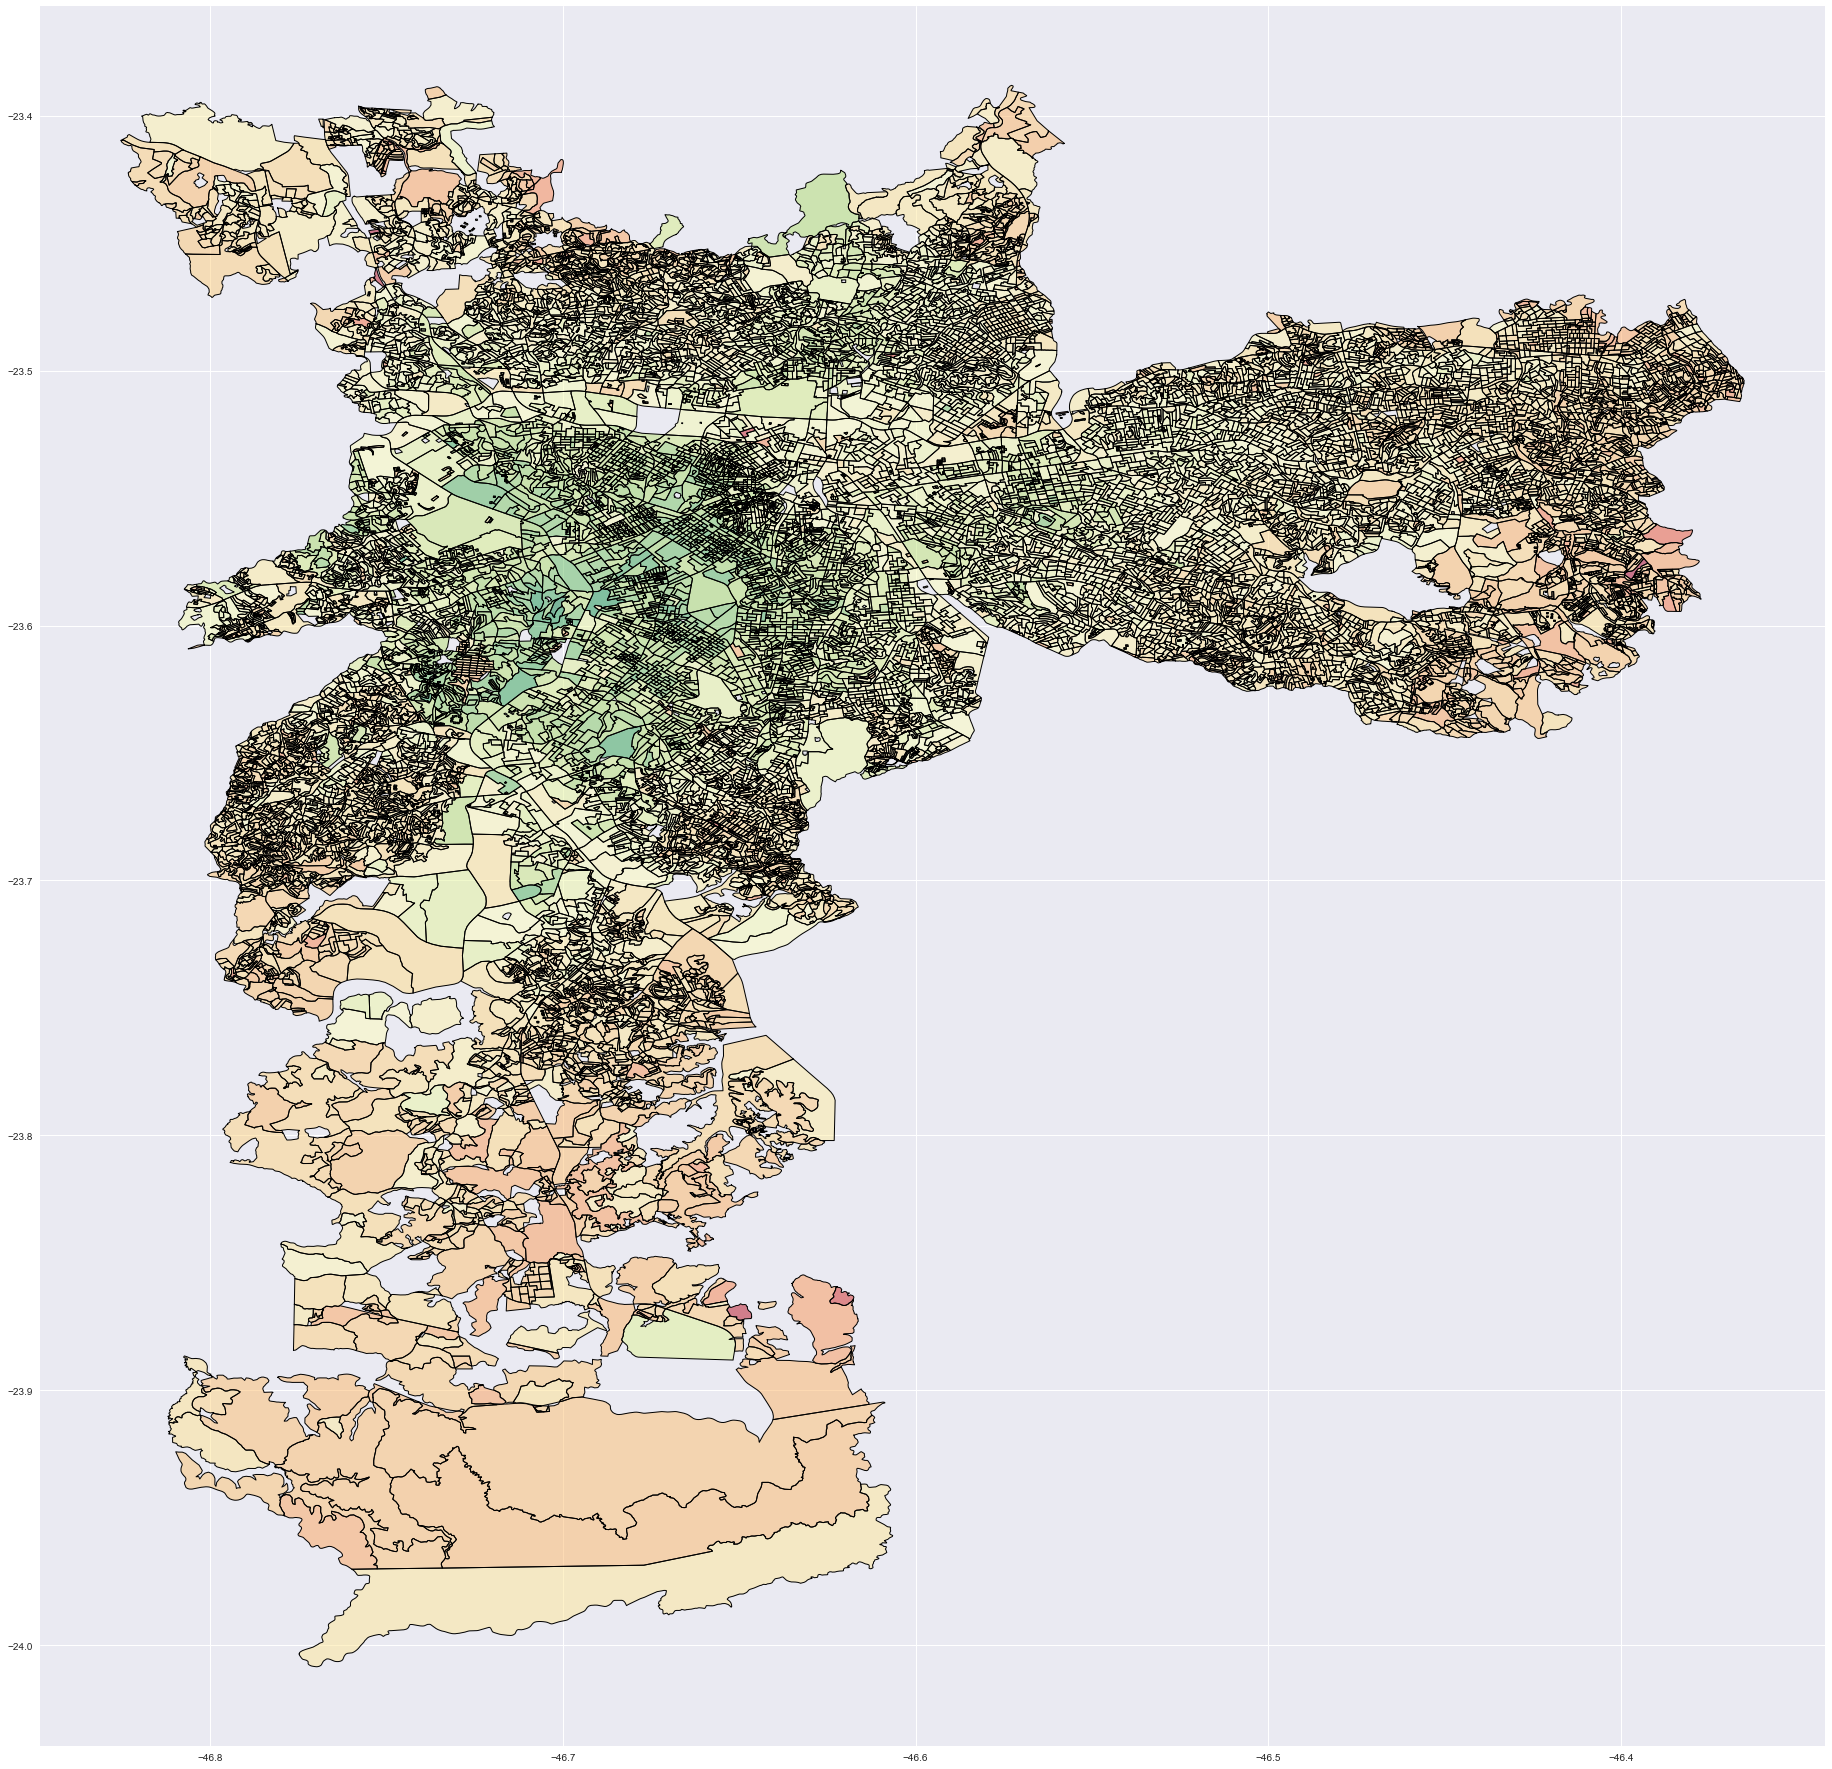

In [108]:
fig, ax = plt.subplots(figsize=(32,32))
df_final[df_final["NM_MUNICIP"] == "SÃO PAULO"].dropna().plot("LOG_MEAN_INCOME",ax=ax, cmap="RdYlGn")
plt.show()

It seems that everything is alright! Finally, let's save our dataset in another Shapefile, so we don't have to keep running this pipeline with we want to follow on another day.

In [115]:
df_final.to_file("./data/income_map/income_map.shp")